In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import scipy
from scipy.stats import poisson
import statistics

In [2]:
def get_data_reg(url_reg, regione):
    date = []
    tot_positivi = []
    nuovi_positivi = []
    source = pd.read_csv(url_reg)
    lista = source.values
    minimo = 847
    massimo = 927
    count = 0

    for line in lista:
        if str(line[3]) == regione:
            count += 1
            if minimo < count < massimo:
                date.append(line[0])
                tot_positivi.append(line[10])
                nuovi_positivi.append(line[12])

    return date, tot_positivi, nuovi_positivi

In [5]:
def main():
    date, tot_positivi, nuovi_positivi = get_data_reg("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv", "Friuli Venezia Giulia")
     
    x = []
    y = []
    z = []
 
    
    x = np.arange(0,len(date))
    y = np.array(tot_positivi)
    z = np.array(nuovi_positivi)
    
    #z = z /10
    
    # disegniamo il grafico
    
    
    plt.plot(x, y)
    plt.show()
    
    plt.plot(x, z)
    plt.plot(x,z, marker = 'o', c = 'b')
    plt.show()
    

#Gompertziana
    def Gompertz(i, N1, b, t0):
    #abbiamo stabilito che N_0 =1
        
        G = N1*math.exp(math.log(1./N1)*(math.exp(-b*np.array(x[i]-t0)))) 
       
        return  G

    def GompertzVar(i, N1, b, t0):
        
        var = Gompertz(x[i],N1, b, t0) - Gompertz(x[i-1], N1, b, t0)
        
        return var



#LikelihoodPoissoniano
    def LogPoissonianLikelihood(x,z,c):
        N1, b, t0 = c
        
        p = [None]*(len(z))
    
        i = 0
        
        for  i in range(0,len(z)):
           
            p[i]=np.log(poisson.pmf(z[i],GompertzVar(x[i],N1,b,t0))+1e-10)

        return np.nansum(p)    


    def log_prior(c):
        N1, b, t0 = c    
        if t0 < 0. and b > 0. and N1 > 0.:
            return 0.0        
        return -np.inf


    def log_probability(c, x, z):        
        lp = log_prior(c)        
        if not np.isfinite(lp):
            return -np.inf
        return lp + LogPoissonianLikelihood(x,z,c)
    
    
    c = [100000., 0.05, -12.]
    
    print(log_probability(c,x,z))
    
    
    from scipy.optimize import minimize

    np.random.seed(1)
    nll = lambda *args:    -log_probability(*args)
    initial = c
    best = minimize(nll, initial ,args=(x,z))
    print(best.x)
    

    plt.plot(x, z, marker = 'o', c = 'b')
    nz = np.zeros(len(z))
    
    for i in range(0,len(z)):
        nz[i] = GompertzVar(i,*best.x)
    
    

    
    plt.plot(x[1:79],nz[1:79],'r')
    plt.show()
  


    import emcee

    pos = best.x * (1.+1e-2 * np.random.randn(32, 3))
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, z)
    )
    sampler.run_mcmc(pos, 1000, progress=True);
    
    
    fig, axes = plt.subplots(3,figsize=(10,7), sharex=True)
    samples = sampler.get_chain()
    print(samples.shape)
    labels = ["$N_1", "b", "$t_0$"]
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i],"k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        
    axes[-1].set_xlabel("step number");

    
    import corner
    flat_samples = sampler.get_chain(discard=100, flat=True)

    fig = corner.corner(flat_samples, labels=labels, show_titles=True)

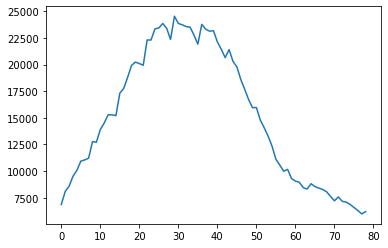

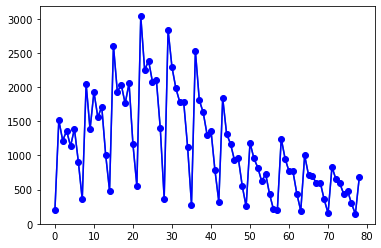

-1604.6958978537643
[ 9.91543107e+04  5.92077180e-02 -1.14574247e+01]


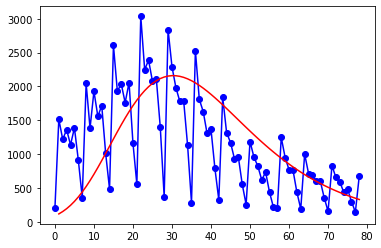

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:18<00:00,  3.87it/s]


(1000, 32, 3)


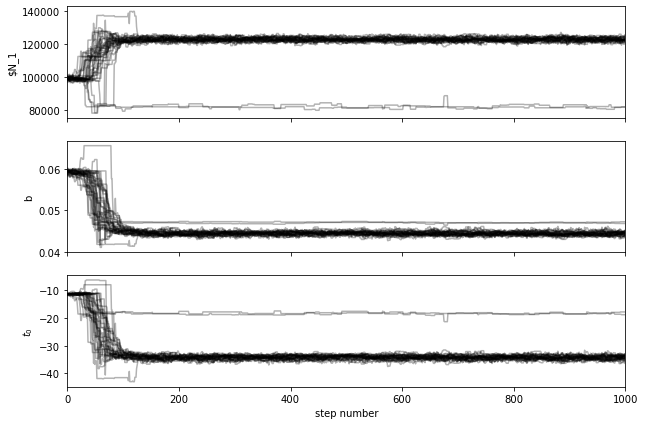

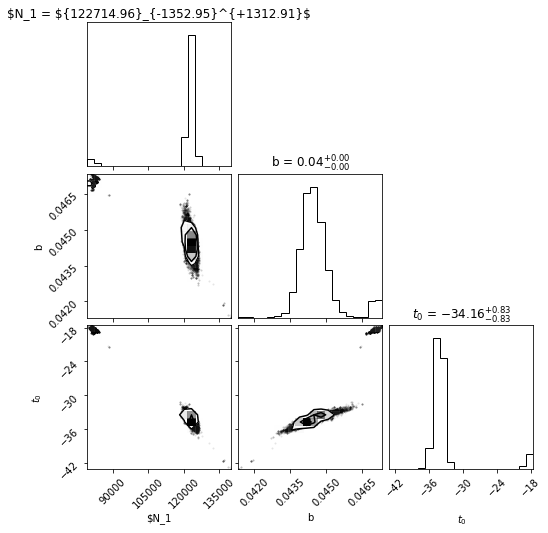

In [6]:
main()
